# Student profiling and performance prediction considering social context

This dataset contains information on the performance of high school students in mathematics, including their grades and demographic information. The data was collected from three high schools in the United States.

The goal of this little project is to investigate a possible relation between social conditions and the student's overall perfomance in math, reading and writing in high school exams. I hope to train a model capable of predicting the student performance based on their social features.  

## Setup

In [92]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import tree 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
import graphviz

## Loading the data

In [93]:
data=pd.read_csv('/kaggle/input/student-performance-in-mathematics/exams.csv')

In [94]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [95]:
data.shape

(1000, 8)

In [96]:
data.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

## Data Pre-Processing and Exploration

In [97]:
data=data.rename(columns={'gender':'gender','race/ethnicity':'race',
                      'parental level of education':'parental_education','lunch':'lunch',
                      'test preparation course':'test_preparation_course','math score':'math_score',
                      'reading score':'reading_score','writing score':'writing_score'})

In [98]:
data.head()

,gender,race,parental_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


The code below shows there's no missing values.

In [99]:
data.isna().sum()

gender                     0
race                       0
parental_education         0
lunch                      0
test_preparation_course    0
math_score                 0
reading_score              0
writing_score              0
dtype: int64

In [100]:
data.describe()

,math_score,reading_score,writing_score
count,1000.000000,1000.000000,1000.000000
mean,67.810000,70.382000,69.140000
std,15.250196,14.107413,15.025917
min,15.000000,25.000000,15.000000
25%,58.000000,61.000000,59.000000
50%,68.000000,70.500000,70.000000
75%,79.250000,80.000000,80.000000
max,100.000000,100.000000,100.000000


The mean and median are relativaly high (I'd expect it to be 50), let's explore deeper and look for any suggestion that social features might inluence the constribution of each student to these numbers. 

In [101]:
for i in range(1,data.shape[1]-3):
    print(data.columns[i])
    print(data[data.columns[i]].value_counts())
    print()

race
group C    323
group D    257
group B    198
group E    143
group A     79
Name: race, dtype: int64

parental_education
some college          224
high school           215
associate's degree    204
some high school      177
bachelor's degree     105
master's degree        75
Name: parental_education, dtype: int64

lunch
standard        660
free/reduced    340
Name: lunch, dtype: int64

test_preparation_course
none         656
completed    344
Name: test_preparation_course, dtype: int64



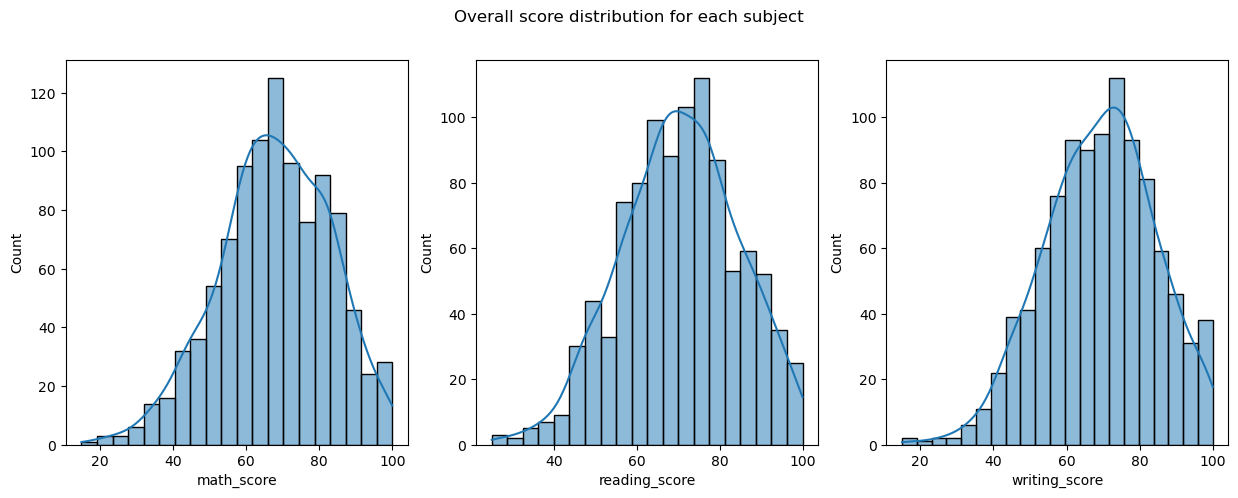

In [102]:
fig, ax = plt.subplots(1,3,sharex=False,figsize=(15,5))
sns.histplot(data['math_score'], ax=ax[0],kde=True)
sns.histplot(data['reading_score'],ax=ax[1],kde=True)
sns.histplot(data['writing_score'],ax=ax[2],kde=True)
fig.suptitle('Overall score distribution for each subject')
plt.show()

In [103]:
data[['reading_score','writing_score','math_score']].corr()

,reading_score,writing_score,math_score
reading_score,1.000000,0.948909,0.811767
writing_score,0.948909,1.000000,0.790055
math_score,0.811767,0.790055,1.000000


Since there's a strong correlation among scores from each subject, I'll consider only math score for this first glance at the data.

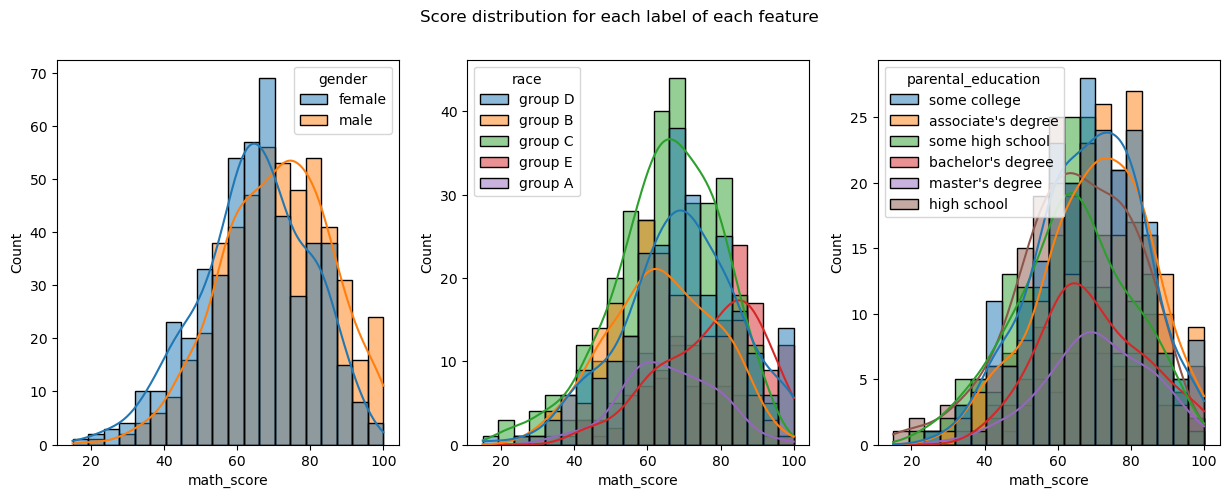

In [104]:
fig, ax = plt.subplots(1,3,sharex=False,figsize=(15,5))
sns.histplot(x=data['math_score'], data=data, ax=ax[0],kde=True,hue='gender')
sns.histplot(x=data['math_score'],data=data, hue='race',ax=ax[1],kde=True)
sns.histplot(x=data['math_score'], data=data, hue = 'parental_education', ax=ax[2],kde=True)

fig.suptitle('Score distribution for each label of each feature')
plt.show()

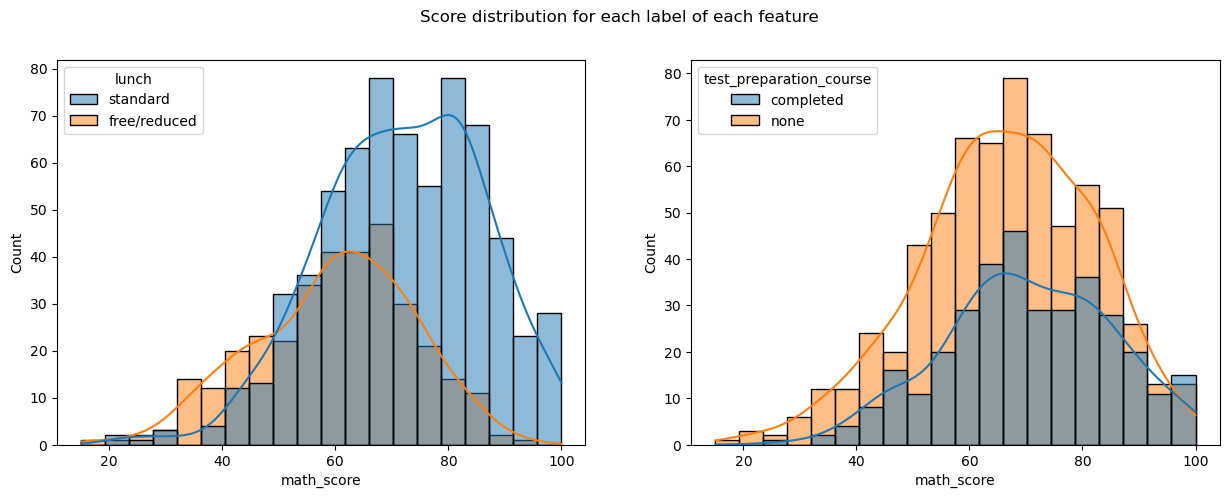

In [105]:
fig, ax = plt.subplots(1,2,sharex=False,figsize=(15,5))
sns.histplot(x=data['math_score'], data=data, ax=ax[0],kde=True,hue='lunch')
sns.histplot(x=data['math_score'],data=data, hue='test_preparation_course',ax=ax[1],kde=True)

fig.suptitle('Score distribution for each label of each feature')
plt.show()

The five plots above shows that social features have some influence on students performance. 

An example of such influence is the plot below, which shows that students whose parents have a master's degree have better math score than students whose parents didn't finish the high school.

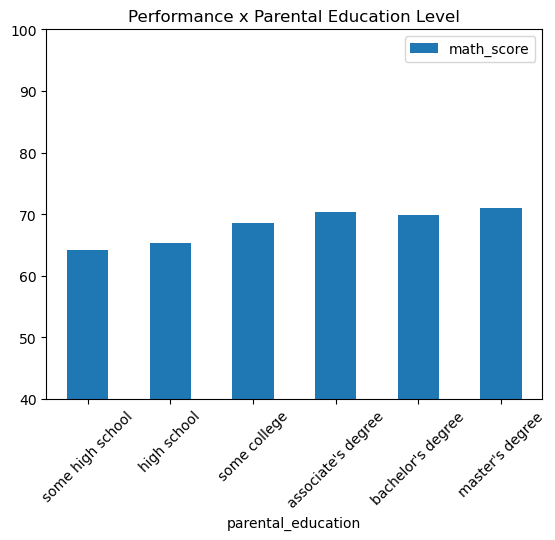

In [106]:
data_parental=data.groupby('parental_education')[['math_score']].mean().reset_index()
data_parental=data_parental.iloc[[5,2,4,0,1,3],:]
data_parental.plot(kind='bar',x='parental_education',rot=45)
plt.ylim(40,100)
plt.title('Performance x Parental Education Level')
plt.show()

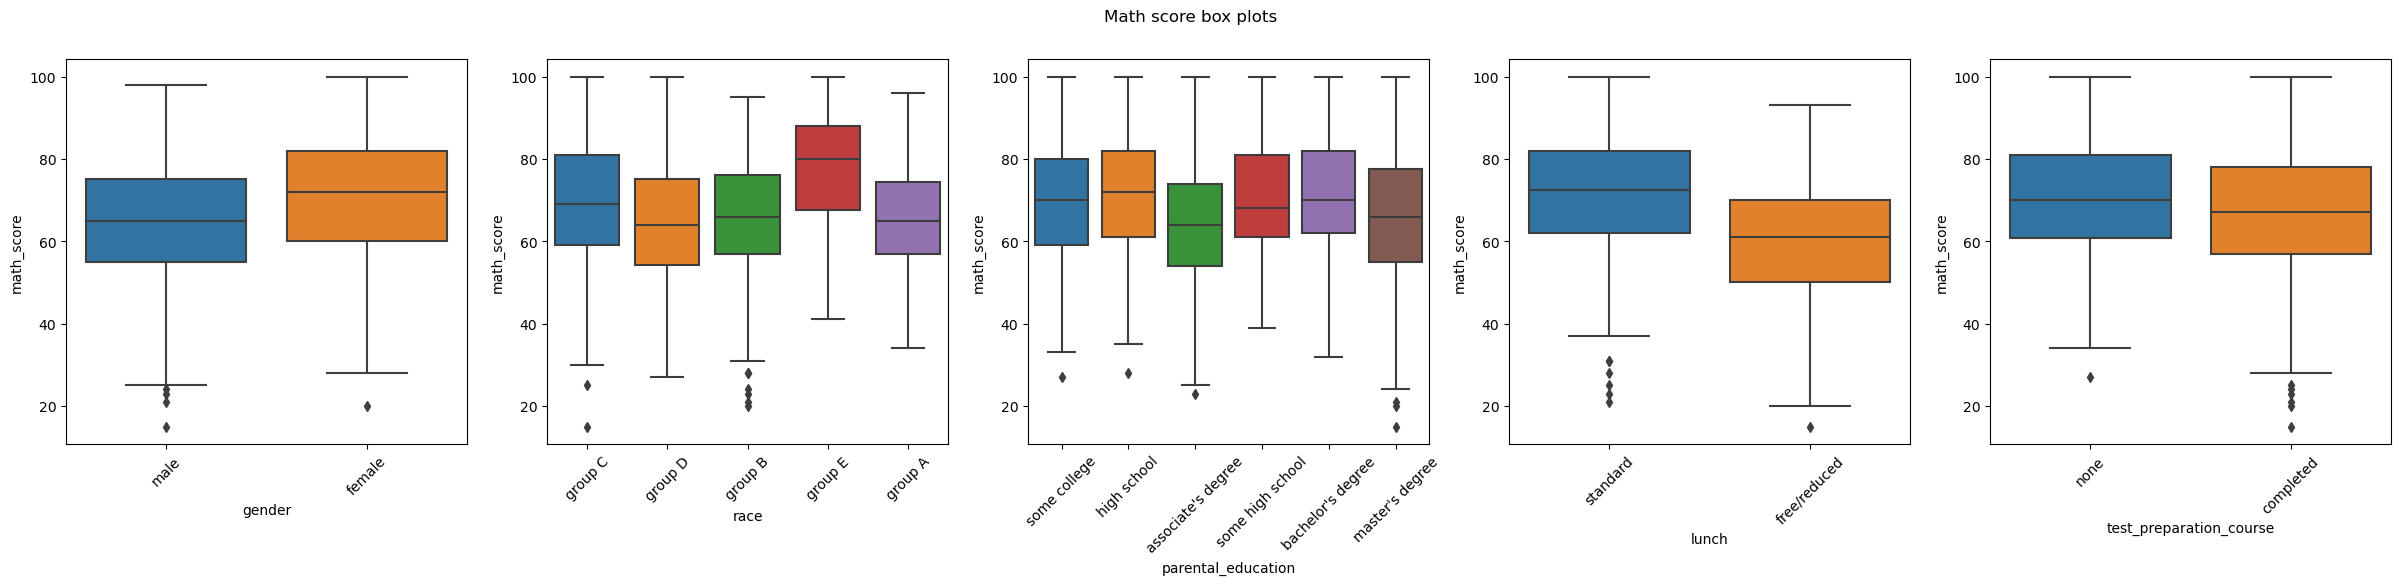

In [107]:
fig, ax = plt.subplots(1,5,sharex=False,figsize=(30,5))
for i in range(5):
    sns.boxplot(data=data,x=data.columns[i],
                y=data.math_score,ax=ax[i]).set_xticklabels(labels=list(data[data.columns[i]].value_counts().index),rotation=45)
fig.suptitle('Math score box plots')
plt.show()

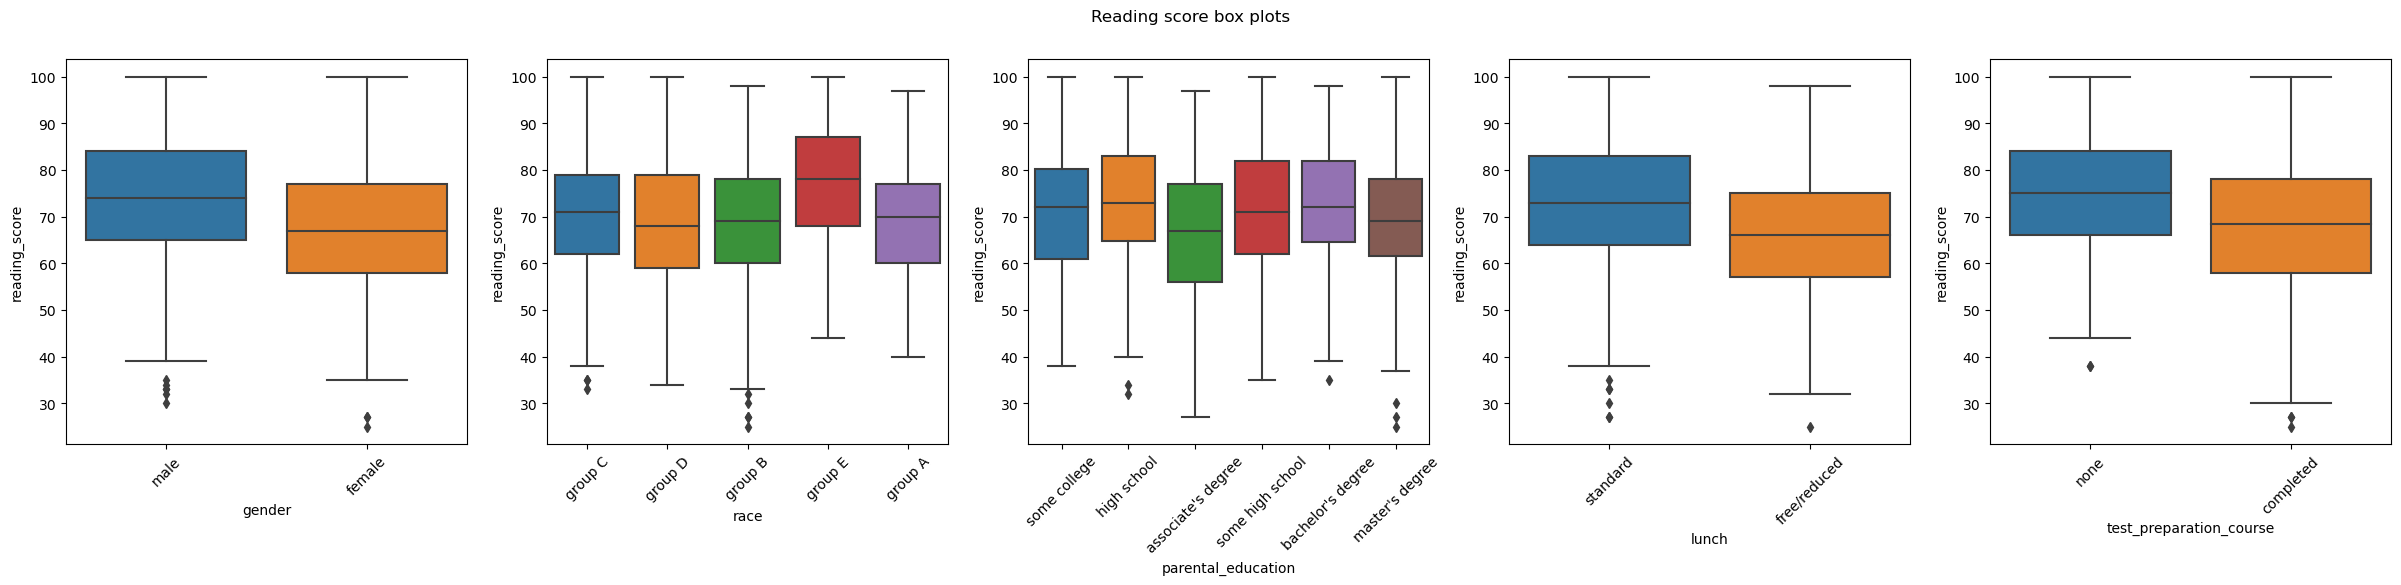

In [108]:
fig, ax = plt.subplots(1,5,sharex=False,figsize=(30,5))
for i in range(5):
    sns.boxplot(data=data,x=data.columns[i],
                y=data.reading_score,ax=ax[i]).set_xticklabels(labels=list(data[data.columns[i]].value_counts().index),rotation=45)
fig.suptitle('Reading score box plots')
plt.show()

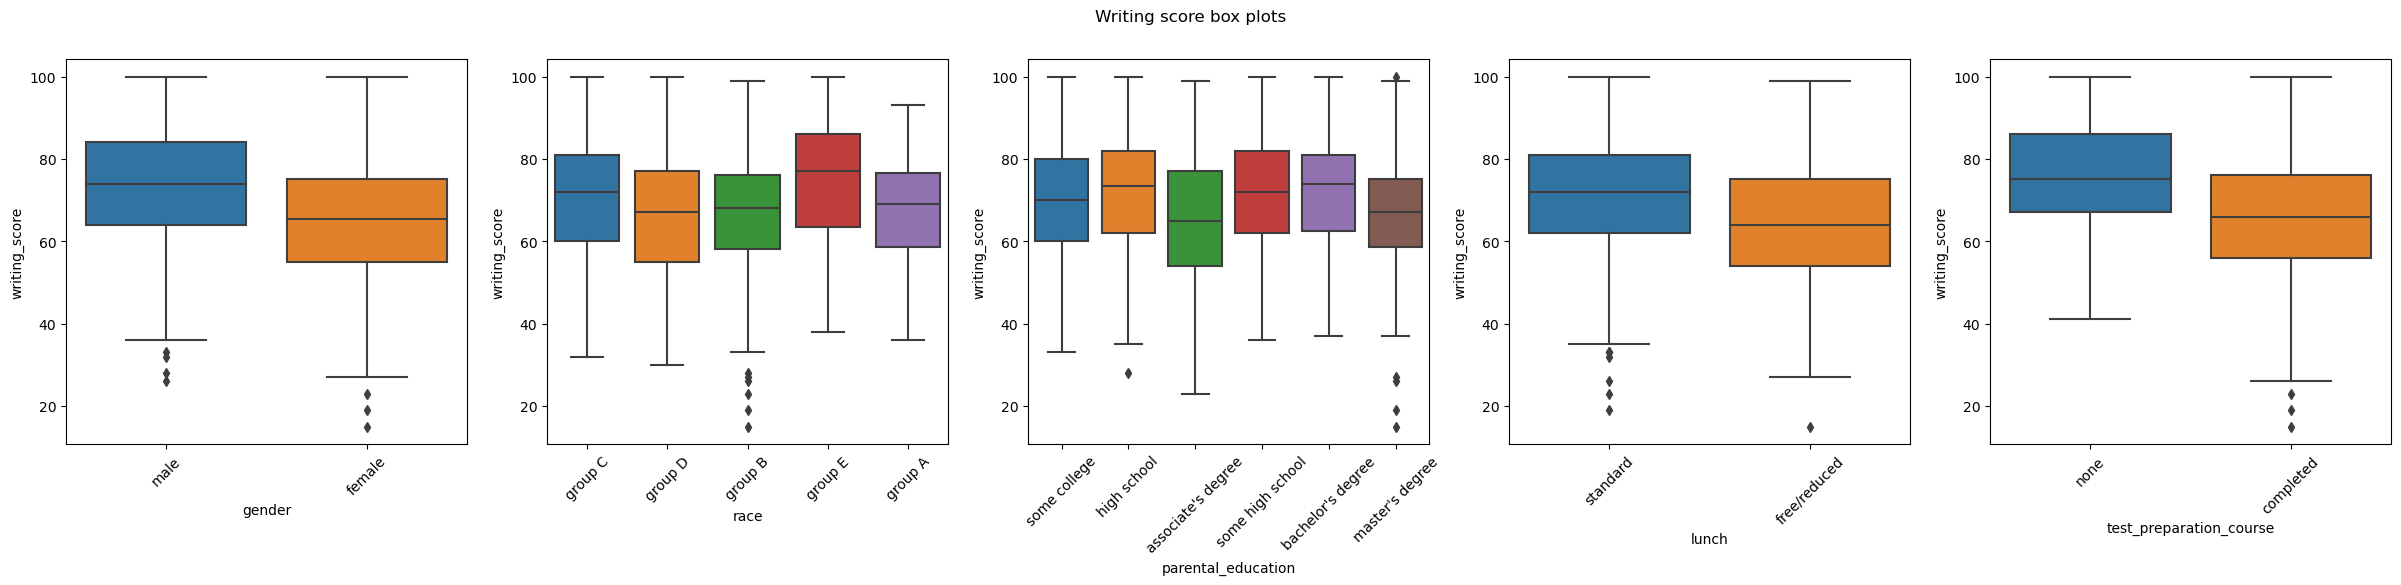

In [109]:
fig, ax = plt.subplots(1,5,sharex=False,figsize=(30,5))
for i in range(5):
    sns.boxplot(data=data,x=data.columns[i],
                y=data.writing_score,ax=ax[i]).set_xticklabels(labels=list(data[data.columns[i]].value_counts().index),rotation=45)
fig.suptitle('Writing score box plots')
plt.show()

The graph above shows, such as the distribution plot, that even though there are difference in the mean score among different groups, there is an overlapping of scores, which means that having a certain social characteristic is not something deterministic. 

I believe the outliers won't bias the model in this case, since there are just a few of them and they are relatively close to the threshold. Nevertheless, for practice's sake, I'll remove from the dataset those entries whose math score is greater than the mean + 2 std or less then mean - 2 std.

In [110]:
upper_threshold=data['math_score'].mean() + 2*data['math_score'].std()

In [111]:
lower_threshold=data['math_score'].mean() - 2*data['math_score'].std()

In [112]:
data_res=data[(data.math_score>lower_threshold)&(data.math_score<upper_threshold)]

In [113]:
data_res.head()

,gender,race,parental_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [114]:
data.shape

(1000, 8)

In [115]:
data_res.shape

(956, 8)

## Data preparation for modeling

I'll cluster the data using K-means based only on score features. Then, having the students labeled based only on their perfomance, I'll train a Decision Tree with the labeled dataset, without the scores, in order to understand better the social nature of the cluterization. 

In [116]:
df_score=data_res[['math_score','reading_score','writing_score']].copy()

In [117]:
df_social=data_res.drop(columns=['math_score','reading_score','writing_score'])

### Preparing for KMeans

In [118]:
#df_score=pd.DataFrame(normalize(df_score))

### Preparing for Decision Tree 

In [119]:
df_social.gender=np.select([df_social.gender=='female',df_social.gender=='male'],[0,1])

In [120]:
df_social.lunch=np.select([df_social.lunch=='standard',df_social.lunch=='free/reduced'],[1,0])

In [121]:
df_social.test_preparation_course=np.select([df_social.test_preparation_course=='completed',
                                      df_social.test_preparation_course=='none'],
                                     [1,0])

In [122]:
parental_education=pd.get_dummies(df_social['parental_education'])

In [123]:
df_social=pd.concat([df_social,parental_education],axis=1)

In [124]:
df_social=df_social.drop('parental_education',axis=1)

In [125]:
race=pd.get_dummies(df_social['race'])

In [126]:
race.rename(columns={'Group A':'race_a','Group B':'race_b','Group C':'race_c',
                      'Group D':'race_d','Group E':'race_e'},inplace=True)

In [127]:
df_social=pd.concat([df_social,race],axis=1)

In [128]:
df_social=df_social.drop('race',axis=1)

In [129]:
df_social.head()

,gender,lunch,test_preparation_course,associate's degree,bachelor's degree,high school,master's degree,some college,some high school,group A,group B,group C,group D,group E
0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
1,1,1,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,1,0,1,0,0,0,0,0,0,0,0,1,0


## KMeans

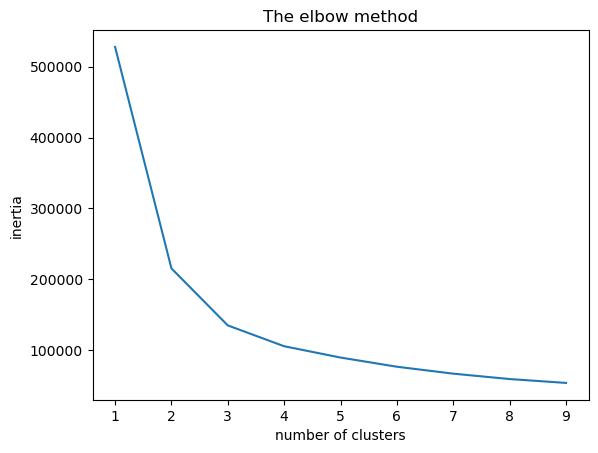

In [130]:
inertia=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_score)
    kmeans.predict(df_score)
    inertia.append(kmeans.inertia_)
sns.lineplot(x=range(1,10),y=inertia) 
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.title('The elbow method')
plt.show()

Since there's no much change in inertia after k=4 and also from k=3 to k=4, I'll work with 3 clusters. Also because it's convenient for the goals of this project.  

In [131]:
kmeans=KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_score)
kmeans.predict(df_score)

array([1, 2, 1, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1,
       2, 1, 0, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 2, 0, 2, 2, 1, 0, 1, 2,
       1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1,
       2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 1, 2, 0, 2, 1, 0, 1, 1, 0, 1,
       2, 2, 2, 1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 0, 1, 2,
       2, 1, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 2,
       2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1,
       2, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 2, 1, 2, 1, 1, 0, 2, 0,
       1, 0, 2, 2, 1, 1, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 1, 2, 0, 1,
       1, 0, 1, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 2,
       2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0,
       0, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0,

In [132]:
df_score_labeled=df_score.copy()
df_score_labeled['group']=kmeans.labels_

In [133]:
df_score_labeled.head()

,math_score,reading_score,writing_score,group
0,59,70,78,1
1,96,93,87,2
2,57,76,77,1
3,70,70,63,1
4,83,85,86,2


In [134]:
df_score_labeled['group'].value_counts()

1    410
2    279
0    267
Name: group, dtype: int64

Let's look at the distribution plot to see if the clusters divided the students accordingly to their permorfance. 

In [135]:
df_score_labeled['overall_score']=df_score_labeled.iloc[:,[0,1,2]].mean(axis=1)

In [136]:
df_score_labeled.head()

,math_score,reading_score,writing_score,group,overall_score
0,59,70,78,1,69.000000
1,96,93,87,2,92.000000
2,57,76,77,1,70.000000
3,70,70,63,1,67.666667
4,83,85,86,2,84.666667


<AxesSubplot:title={'center':'Overall score distribution plot'}, xlabel='overall_score', ylabel='Density'>

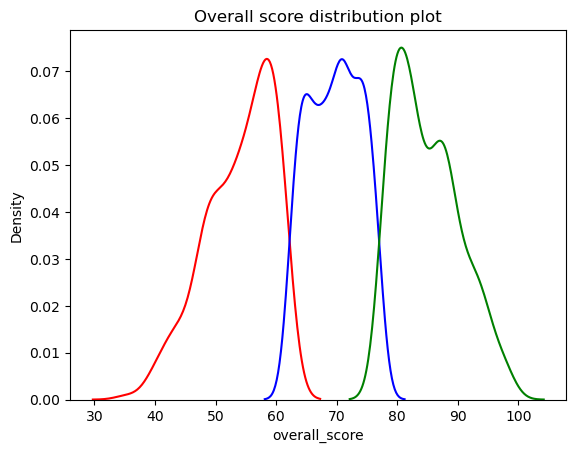

In [137]:
plt.title('Overall score distribution plot')
sns.kdeplot(x=df_score_labeled[df_score_labeled.group==0]['overall_score'], data=data,color='red')
sns.kdeplot(x=df_score_labeled[df_score_labeled.group==1]['overall_score'], data=data,color='blue')
sns.kdeplot(x=df_score_labeled[df_score_labeled.group==2]['overall_score'], data=data,color='green')


Now, lets rename the labels and investigate the groups a little deeper before going into the decision tree modeling. 

In [138]:
labels=np.select([df_score_labeled.group==0,df_score_labeled.group==1,
                 df_score_labeled.group==2],['A','B','C'])

In [139]:
df_score_labeled['group']=labels

In [140]:
df_score_labeled.head()

,math_score,reading_score,writing_score,group,overall_score
0,59,70,78,B,69.000000
1,96,93,87,C,92.000000
2,57,76,77,B,70.000000
3,70,70,63,B,67.666667
4,83,85,86,C,84.666667


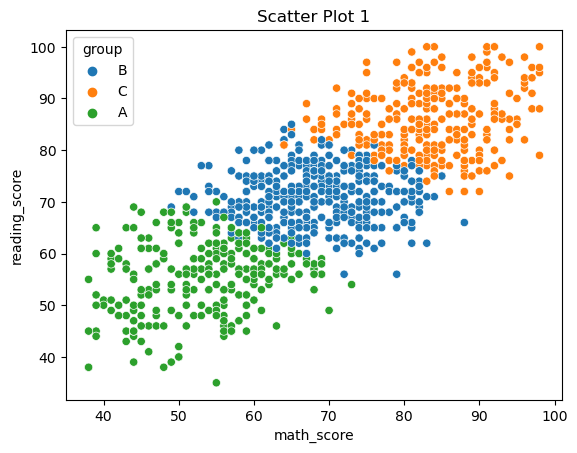

In [141]:
sns.scatterplot(x=df_score_labeled.iloc[:,0],y=df_score_labeled.iloc[:,1],hue='group',data=df_score_labeled)
plt.xlabel('math_score')
plt.ylabel('reading_score')
plt.title('Scatter Plot 1')
plt.show()

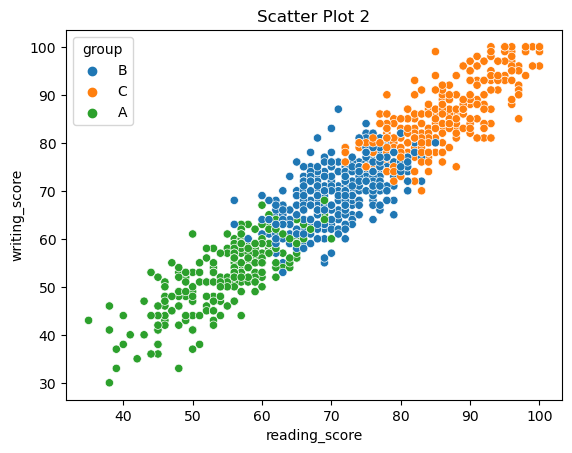

In [142]:
sns.scatterplot(x=df_score_labeled.iloc[:,1],y=df_score_labeled.iloc[:,2],hue='group',data=df_score_labeled)
plt.xlabel('reading_score')
plt.ylabel('writing_score')
plt.title('Scatter Plot 2')
plt.show()

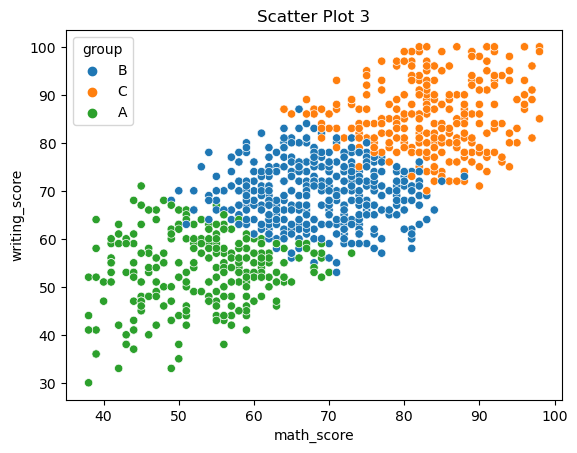

In [143]:
sns.scatterplot(x=df_score_labeled.iloc[:,0],y=df_score_labeled.iloc[:,2],hue='group',data=df_score_labeled)
plt.xlabel('math_score')
plt.ylabel('writing_score')
plt.title('Scatter Plot 3')
plt.show()

In [144]:
#math score
df_score_labeled.groupby('group')[df_score_labeled.columns[0]].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,267.0,53.303371,7.815645,38.0,47.0,54.0,59.0,73.0
B,410.0,68.475610,7.277298,49.0,63.0,68.0,74.0,88.0
C,279.0,83.311828,7.332757,64.0,79.0,83.0,88.5,98.0


In [145]:
#reading score
df_score_labeled.groupby('group')[df_score_labeled.columns[1]].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,267.0,55.397004,6.859469,35.0,50.0,56.0,60.0,70.0
B,410.0,70.804878,5.409037,56.0,67.0,71.0,75.0,85.0
C,279.0,86.035842,6.560082,72.0,81.0,86.0,91.0,100.0


In [146]:
#writing score
df_score_labeled.groupby('group')[df_score_labeled.columns[2]].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,267.0,53.284644,7.520990,30.0,48.0,54.0,59.0,71.0
B,410.0,69.760976,6.164132,53.0,65.0,70.0,74.0,87.0
C,279.0,85.584229,7.281041,70.0,80.0,85.0,90.0,100.0


In [147]:
#overall score
df_score_labeled.groupby('group')[df_score_labeled.columns[4]].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,267.0,53.995006,5.705160,35.333333,49.833333,55.333333,58.666667,61.666667
B,410.0,69.680488,4.303682,62.000000,66.000000,70.000000,73.333333,77.333333
C,279.0,84.977300,5.329424,77.333333,80.666667,84.000000,88.666667,99.000000


Group A: bad perfomance
Group B: medium perfomance
Group C: high perfomance

In [148]:
labels=np.select([df_score_labeled.group=='A',df_score_labeled.group=='B',
                 df_score_labeled.group=='C'],['bad','medium','high'])

## Decision tree

In [149]:
df_social['performance']=labels

In [150]:
df_social.head()

,gender,lunch,test_preparation_course,associate's degree,bachelor's degree,high school,master's degree,some college,some high school,group A,group B,group C,group D,group E,performance
0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,medium
1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,high
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,medium
3,1,0,0,0,0,0,0,1,0,0,1,0,0,0,medium
4,0,1,0,1,0,0,0,0,0,0,0,0,1,0,high


In [151]:
df_social['performance'].value_counts()

medium    410
high      279
bad       267
Name: performance, dtype: int64

Since the dataset is unbalanced, I'm gonna remove 100 rows from group 'medium'.

In [152]:
df_medium=df_social[df_social.performance=='medium']
df_medium=df_medium.sample(100)
index_to_drop=list(df_medium.index)

In [153]:
df_social_res=df_social.drop(index_to_drop)
df_social_res['performance'].value_counts()

medium    310
high      279
bad       267
Name: performance, dtype: int64

In [154]:
x=df_social_res.drop('performance',axis=1)
y=df_social_res['performance']

In [155]:
x.head()

,gender,lunch,test_preparation_course,associate's degree,bachelor's degree,high school,master's degree,some college,some high school,group A,group B,group C,group D,group E
0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
1,1,1,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [156]:
y.head()

0    medium
1      high
2    medium
3    medium
4      high
Name: performance, dtype: object

In [157]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2,random_state=42)

### Grid search

In [158]:
tree_clf=tree.DecisionTreeClassifier()
param_grid=[{'random_state':[42],'max_depth':[2,3,4,5,6,7,8],'criterion':['entropy']}]
grid_search = GridSearchCV(tree_clf, param_grid, cv=5,scoring='accuracy',
                           return_train_score=True)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 8],
                          'random_state': [42]}],
             return_train_score=True, scoring='accuracy')

In [159]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'random_state': 42}

In [160]:
tree_clf_final=grid_search.best_estimator_

In [161]:
tree_clf_final.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

### Validation

In [162]:
y_hat_test = tree_clf_final.predict(x_test)
y_hat_train = tree_clf_final.predict(x_train)

In [163]:
target_names = y.unique()
print(classification_report(y_hat_train, y_train, target_names=target_names))

              precision    recall  f1-score   support

      medium       0.62      0.54      0.58       250
        high       0.52      0.68      0.59       172
         bad       0.52      0.48      0.50       262

    accuracy                           0.55       684
   macro avg       0.55      0.57      0.55       684
weighted avg       0.56      0.55      0.55       684



In [164]:
print(classification_report(y_hat_test, y_test, target_names=target_names))

              precision    recall  f1-score   support

      medium       0.52      0.41      0.46        63
        high       0.43      0.53      0.48        43
         bad       0.38      0.39      0.39        66

    accuracy                           0.44       172
   macro avg       0.44      0.45      0.44       172
weighted avg       0.44      0.44      0.44       172



The model is underfitted and generalizes poorly. Nevertheless, these results could mean that it's not possible to predict with high accuracy the student performance based on ther social features, which means that social features do not absolutely determine their perfomance, even though there is some influence. 

### Plotting tree

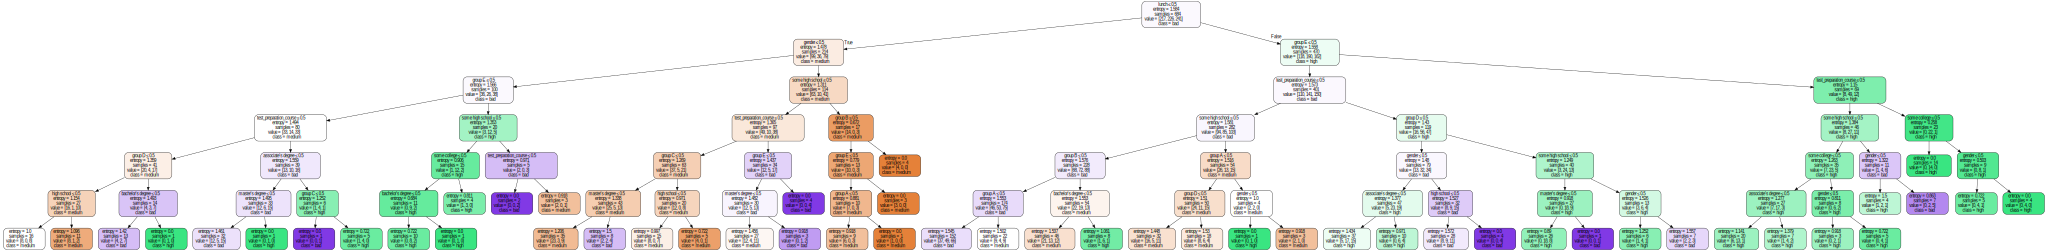

In [165]:
dot_data = tree.export_graphviz(tree_clf_final, out_file=None, 
                     feature_names=list(x.columns),  
                     class_names=list(y.value_counts().index),  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Conclusion

That was fun! It was my first attempt to go from a practice exercise into something a little more detailed by myself. 

I understand that the results were inconclusive. The decision tree I trained wasn't robust enough to explain the different performance groups. Actually, the exploratory analysis at the beginning of this notebook was much more successful in showing that might be a relation between social conditions and student perfomance. There are still a lot to be done, tho.

I hope this notebook can help other people who are beginners like me and I also look forward for tips from those who have more experience than me :)  